In [1]:
# Instalar la versión CORRECTA de OpenCV y luego importar

# Desinstalar primero para evitar conflictos (el -y evita la pregunta de confirmación)
!pip uninstall opencv-python -y
!pip uninstall opencv-contrib-python -y # Asegurarse de quitar ambas si existen

# Instalar la versión que incluye los módulos contrib
!pip install opencv-contrib-python

# --- IMPORTANTE ---
# Después de ejecutar esta celda, DEBES REINICIAR EL ENTORNO DE EJECUCIÓN.
# En Colab: Ve a "Entorno de ejecución" -> "Reiniciar entorno de ejecución..."
# Luego, vuelve a ejecutar todas las celdas desde el principio.
# ------------------

Found existing installation: opencv-contrib-python 4.11.0.86
Uninstalling opencv-contrib-python-4.11.0.86:
  Successfully uninstalled opencv-contrib-python-4.11.0.86
  Using cached opencv_contrib_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_contrib_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (69.1 MB)


# Laboratorio Integrador: Detección de Rostros y Puntos Faciales Clave (Landmarks)

**Objetivo:** En esta práctica integradora, aplicaremos y conectaremos dos técnicas importantes de Visión por Computadora que hemos visto:

1.  **Detección de Rostros:** Utilizaremos el método de Haar Cascades para encontrar la ubicación de múltiples caras dentro de una imagen.
2.  **Detección de Landmarks Faciales:** Una vez localizadas las caras, aplicaremos un modelo más avanzado (LBF) para identificar 68 puntos clave específicos en cada rostro (ojos, cejas, nariz, boca, mandíbula).

**Contexto:** Estas técnicas son fundamentales en muchas aplicaciones, desde filtros de redes sociales y sistemas de reconocimiento facial hasta análisis de expresiones o detección de somnolencia en conductores.

**Imagen de Trabajo:** Usaremos una icónica imagen de la película argentina "Nueve Reinas".

**¡Manos a la obra!**

## Sección 0: Configuración del Entorno

Antes de comenzar, necesitamos asegurarnos de tener las librerías adecuadas y descargar los archivos necesarios (imagen, modelos pre-entrenados).

### 0.1 Instalación e Importación de Librerías

*   **`opencv-python` (`cv2`):** Librería esencial para visión por computadora.
*   **`opencv-contrib-python`:** Contiene módulos extra de OpenCV, incluyendo `cv2.face` que usaremos para los landmarks. A menudo, instalar este paquete reemplaza o incluye `opencv-python`.
*   **`matplotlib.pyplot` (`plt`):** Para visualizar imágenes dentro del cuaderno.
*   **`numpy` (`np`):** Para manejo eficiente de arrays (las imágenes son arrays).

In [89]:
# Instalar librerías (si es necesario) y luego importar
# Usamos %%capture para ocultar la salida detallada de la instalación.
#%%capture
#!pip uninstall opencv-python -y # Desinstalar versión base si existe
#!pip install matplotlib opencv-contrib-python # Instalar versión con módulos extra

import cv2
import numpy as np
import matplotlib.pyplot as plt

print("Librerías importadas.")

Librerías importadas.


### 0.2 Descarga de Recursos

Descargaremos:

1.  **Imagen:** `9reinas.jpg`.
2.  **Clasificador Haar:** `haarcascade_frontalface_default.xml`. Lo descargaremos directamente del repositorio oficial de OpenCV en GitHub. Este archivo contiene los patrones Haar pre-calculados para detectar rostros frontales.
3.  **Modelo de Landmarks LBF:** `lbfmodel.yaml`. Este es un modelo pre-entrenado específico para el algoritmo LBF (Local Binary Features) de detección de landmarks. (Usaremos el enlace del cuaderno original, ya que es una fuente común para este archivo específico). *Nota: Este archivo es grande (~70Mb) y puede tardar un poco.*

In [3]:
# Descargar archivos necesarios

# Descargar clasificador Haar desde el repositorio oficial de OpenCV
!wget -q https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml -O haarcascade_frontalface_default.xml
print("Clasificador Haar descargado.")

# Descargar modelo de landmarks LBF (puede tardar)
# Usamos %%capture para ocultar la salida si es muy larga
#%%capture
!wget https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml -O lbfmodel.yaml
print("Modelo LBF para landmarks descargado.")
print("¡Recursos listos!")

Clasificador Haar descargado.
--2025-05-13 03:24:54--  https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kurnianggoro/GSOC2017/master/data/lbfmodel.yaml [following]
--2025-05-13 03:24:54--  https://raw.githubusercontent.com/kurnianggoro/GSOC2017/master/data/lbfmodel.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56375857 (54M) [text/plain]
Saving to: ‘lbfmodel.yaml’

lbfmodel.yaml       100%[===================>]  53.76M   204MB/s    in 0.3s    

2025-05-13 03:25:57 (204 MB/s) - ‘lbfmodel.yaml’ saved [56375857/56375857]



### 0.3 Carga Inicial de la Imagen

Cargamos la imagen descargada usando `cv2.imread`.

In [90]:
# Cargar la imagen original
img = cv2.imread("cara_img.jpg")

if img is None:
  print("Error al cargar la imagen 'cara_img.jpg'. Verifica la ruta.")
else:
  print("Imagen original cargada (formato BGR). Dimensiones:", img.shape)

Imagen original cargada (formato BGR). Dimensiones: (5760, 3840, 3)


## Sección 1: Detección de Rostros con Haar Cascades

**Concepto:** Las Haar Cascades son un método rápido basado en características visuales simples (diferencias de intensidad en patrones tipo Haar) para detectar objetos, en este caso, rostros. El clasificador (`.xml`) contiene una "cascada" de filtros: la imagen pasa por filtros cada vez más específicos, y si falla en uno temprano, se descarta rápidamente, haciendo el proceso eficiente. Funciona mejor en escala de grises.

### 1.1 **Ejercicio 1:** Convertir la Imagen a RGB

OpenCV carga en BGR. Para mostrar con Matplotlib, la convertimos a RGB.

In [91]:
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print("Imagen RGB cargada. Dimensiones:", img_RGB.shape)

Imagen RGB cargada. Dimensiones: (5760, 3840, 3)


### 1.2 **Ejercicio 2:** Convertir la Imagen a Escala de Grises

El detector Haar necesita la imagen en escala de grises.

In [92]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print("Imagen gris cargada. Dimensiones:", img_gray.shape)

Imagen gris cargada. Dimensiones: (5760, 3840)


### 1.3 **Ejercicio 3:** Cargar Clasificador y Detectar Rostros

Cargamos el archivo `.xml` y usamos el método `detectMultiScale` sobre la imagen gris. Este método busca caras en diferentes tamaños y devuelve una lista de rectángulos `(x, y, ancho, alto)` por cada cara encontrada.

In [93]:
import xml.etree.ElementTree as ET

# Load the XML file
try:
    tree = ET.parse('haarcascade_frontalface_default.xml')
    root = tree.getroot()
    # Now you can process the XML data using 'root'
    print("XML file loaded successfully.")

except FileNotFoundError:
    print("Error: XML file not found.")
except ET.ParseError:
    print("Error: Invalid XML file format.")

# Create a face cascade classifier object
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Example usage of detectMultiScale:
faces = face_cascade.detectMultiScale(img_gray, scaleFactor=1.05, minNeighbors=10, minSize=(150, 150))


XML file loaded successfully.


### 1.4 **Ejercicio 4:** Dibujar Bounding Boxes y Nombres

Visualizamos los resultados dibujando rectángulos y nombres sobre la imagen RGB.

**Tarea:** Dibuja la bounding box de Darín en rojo y la de Pauls en verde. Añade sus nombres encima.
*Asumiremos que `faces[0]` es Pauls y `faces[1]` es Darín según el orden de detección típico (puede variar).*

<Figure size 640x480 with 0 Axes>

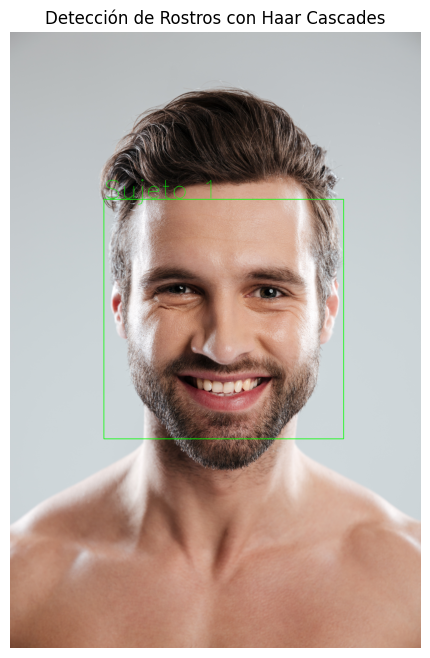

In [94]:
# Create a copy of the original image
img_with_detections = img_RGB.copy()

# Dibujar rectángulos (bounding boxes) alrededor de las caras detectadas
#print (faces.size)
for i, (x, y, w, h) in enumerate(faces):
    if i == 0:
        color = (0, 255, 0)
        name = "Sujeto 1"
    elif i == 1:
        color = (255, 0, 0)
        name = "Sujeto 2"
    else:
        color = (0, 0, 255)
        name = f"Sujeto {i+1}"

    cv2.rectangle(img_with_detections, (x, y), (x + w, y + h), color, 5)  # Dibujar rectángulo
    cv2.putText(img_with_detections, name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 8, color, 3) # Agregar nombre

plt.clf() # Clear the current figure
# Mostrar la imagen con las bounding boxes
plt.figure(figsize=(10, 8))
plt.imshow(img_with_detections)
plt.axis('off')
plt.title('Detección de Rostros con Haar Cascades')
plt.show()


In [95]:
# Cargar 2da imagen de prueba
img_mul = cv2.imread("varias_personas.jpg")

if img_mul is None:
  print("Error al cargar la imagen 'varias_personas.jpg'. Verifica la ruta.")
else:
  print("Imagen original cargada (formato BGR). Dimensiones:", img_mul.shape)

Imagen original cargada (formato BGR). Dimensiones: (4912, 7360, 3)


In [96]:
img_M_RGB = cv2.cvtColor(img_mul, cv2.COLOR_BGR2RGB)
print("Imagen RGB cargada. Dimensiones:", img_M_RGB.shape)

Imagen RGB cargada. Dimensiones: (4912, 7360, 3)


In [97]:
img_M_gray = cv2.cvtColor(img_mul, cv2.COLOR_BGR2GRAY)
print("Imagen gris cargada. Dimensiones:", img_M_gray.shape)

Imagen gris cargada. Dimensiones: (4912, 7360)


In [98]:
#Vamos a probar con una foto con varios rostros.

# Create a face cascade classifier object
face_cascade_2 = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Example usage of detectMultiScale:
faces_2 = face_cascade.detectMultiScale(img_M_gray, scaleFactor=1.1, minNeighbors=8, minSize=(20, 20))


<Figure size 640x480 with 0 Axes>

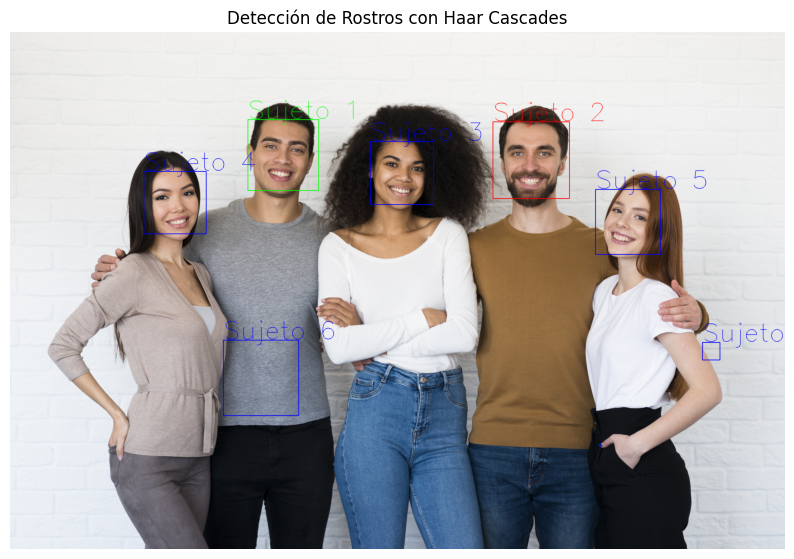

In [99]:
img_with_detections2 = img_M_RGB.copy()

# Dibujar rectángulos (bounding boxes) alrededor de las caras detectadas
for i, (x, y, w, h) in enumerate(faces_2):
    if i == 0:
        color = (0, 255, 0)
    elif i == 1:
        color = (255, 0, 0)
    else:
        color = (0, 0, 255)

    name = f"Sujeto {i+1}"

    cv2.rectangle(img_with_detections2, (x, y), (x + w, y + h), color, 5)  # Dibujar rectángulo
    cv2.putText(img_with_detections2, name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 8, color, 3) # Agregar nombre

plt.clf() # Clear the current figure
# Mostrar la imagen con las bounding boxes
plt.figure(figsize=(10, 8))
plt.imshow(img_with_detections2)
plt.axis('off')
plt.title('Detección de Rostros con Haar Cascades')
plt.show()


Conclusión:  Se logró detectar varios rostros diferentes, aunque aún se detectan 2 falsos positivos (Sujetos 6 y 7).  Para evitarlo hay que seguir cambiando los parámetros del método detectMultiScale.  En diferentes pruebas, ya se eliminaron 2 falsos positivos de los 4 que se mostraron en la primera ejecución.

## Sección 2: Detección de Landmarks Faciales con LBF

**Concepto:** Una vez ubicada una cara (con su bounding box), podemos usar un detector de landmarks para encontrar puntos precisos en ella. El método LBF (Local Binary Features) usa un modelo (`lbfmodel.yaml`) entrenado para localizar 68 puntos estándar en el rostro. Necesita la imagen en escala de grises y las bounding boxes como entrada.

### 2.1 Cargar Modelo y Detectar Landmarks

### 2.2 Procesar y Visualizar Landmarks (Sujeto1)

Los landmarks vienen en un formato específico (array 3D, tipo float). Los procesamos para obtener un array 2D de enteros `(x, y)` para cada uno de los 68 puntos del primer rostro (Sujeto1) y los dibujamos.

In [100]:
# Cargar el detector de landmarks y aplicarlo

if img_gray is not None and len(faces) > 0:
  # Creamos el detector
  landmark_detector = cv2.face.createFacemarkLBF()
  # Cargamos el modelo
  try:
    landmark_detector.loadModel("lbfmodel.yaml")
    print("Modelo LBF cargado.")

    # Aplicamos el detector ('fit')
    # Recibe la imagen GRIS y las bounding boxes 'faces'
    ok, all_landmarks = landmark_detector.fit(img_gray, faces)

    if ok:
      print(f"Se detectaron landmarks para {len(all_landmarks)} rostro(s).")
      # all_landmarks es una lista, cada elemento es un array de landmarks para una cara
    else:
      print("Error durante la detección de landmarks con .fit()")
      all_landmarks = None

  except cv2.error as e:
    print(f"Error cargando o usando el modelo LBF: {e}")
    print("Asegúrate que 'lbfmodel.yaml' se descargó correctamente.")
    all_landmarks = None
else:
  print("Se requiere la imagen gris y las caras detectadas ('faces').")
  all_landmarks = None

Modelo LBF cargado.
Se detectaron landmarks para 1 rostro(s).


Landmarks Sujeto 1 procesados. Forma: (68, 2)

Dibujando landmarks de Sujeto 1 (verde):


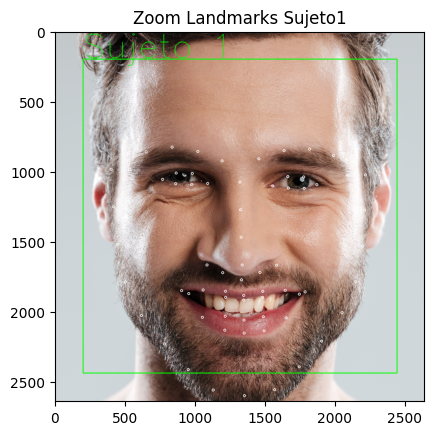

In [101]:
# Procesar y dibujar landmarks de Sujeto1

if all_landmarks is not None and len(all_landmarks) >= 1:
  # Landmarks del primer rostro (indice 0)
  landmarks_s1 = all_landmarks[0]
  # Quitar dimensión extra y convertir a enteros
  landmarks_s1 = landmarks_s1[0].astype(int)
  print("Landmarks Sujeto 1 procesados. Forma:", landmarks_s1.shape)

  # Dibujar sobre la imagen 'img_rgb' (que ya tiene boxes/nombres)
  print("\nDibujando landmarks de Sujeto 1 (verde):")

  # Get the bounding box of the first face
  x, y, w, h = faces[0]

  # Adjust the margin to ensure landmarks are included in the zoomed region
  margin = 200

  # Select the region with the face plus a margin
  face_region = img_with_detections[y - margin:y + h + margin, x - margin:x + w + margin]

  # Iterate through landmarks and draw them on the face_region
  for lx, ly in landmarks_s1:
      # Check if the landmark falls within the zoomed region
      if (x - margin < lx < x + w + margin) and (y - margin < ly < y + h + margin):
          # Adjust landmark coordinates relative to the zoomed region
          lx_zoomed = lx - (x - margin)
          ly_zoomed = ly - (y - margin)
          cv2.circle(face_region, (lx_zoomed, ly_zoomed), 8, (255, 255, 255), 4)

  # Display the zoomed image with landmarks
  plt.imshow(face_region)
  plt.title("Zoom Landmarks Sujeto1")

else:
  print("No hay landmarks disponibles para procesar.")


####Repetimos el procedimiento para la foto con varios rostros.

In [102]:
#img_with_detections2  Haremos el mismo proceso con la imagen de varios rostros, y
#obtendremos los landmarks de dos de las personas.


In [103]:
# Cargar el detector de landmarks y aplicarlo

if img_M_gray is not None and len(faces_2) > 0:
  # Creamos el detector
  landmark_detector2 = cv2.face.createFacemarkLBF()
  # Cargamos el modelo
  try:
    landmark_detector2.loadModel("lbfmodel.yaml")
    print("Modelo LBF cargado.")

    # Aplicamos el detector ('fit')
    # Recibe la imagen GRIS y las bounding boxes 'faces'
    ok, all_landmarks = landmark_detector2.fit(img_M_gray, faces_2)

    if ok:
      print(f"Se detectaron landmarks para {len(all_landmarks)} rostro(s).")
      # all_landmarks es una lista, cada elemento es un array de landmarks para una cara
    else:
      print("Error durante la detección de landmarks con .fit()")
      all_landmarks = None

  except cv2.error as e:
    print(f"Error cargando o usando el modelo LBF: {e}")
    print("Asegúrate que 'lbfmodel.yaml' se descargó correctamente.")
    all_landmarks = None
else:
  print("Se requiere la imagen gris y las caras detectadas ('faces').")
  all_landmarks = None

Modelo LBF cargado.
Se detectaron landmarks para 7 rostro(s).


Landmarks Sujeto 2 procesados. Forma: (68, 2)

Dibujando landmarks de Sujeto 2:
Landmarks Sujeto 4 procesados. Forma: (68, 2)

Dibujando landmarks de Sujeto 4:
Landmarks de los Sujetos 2 y 4


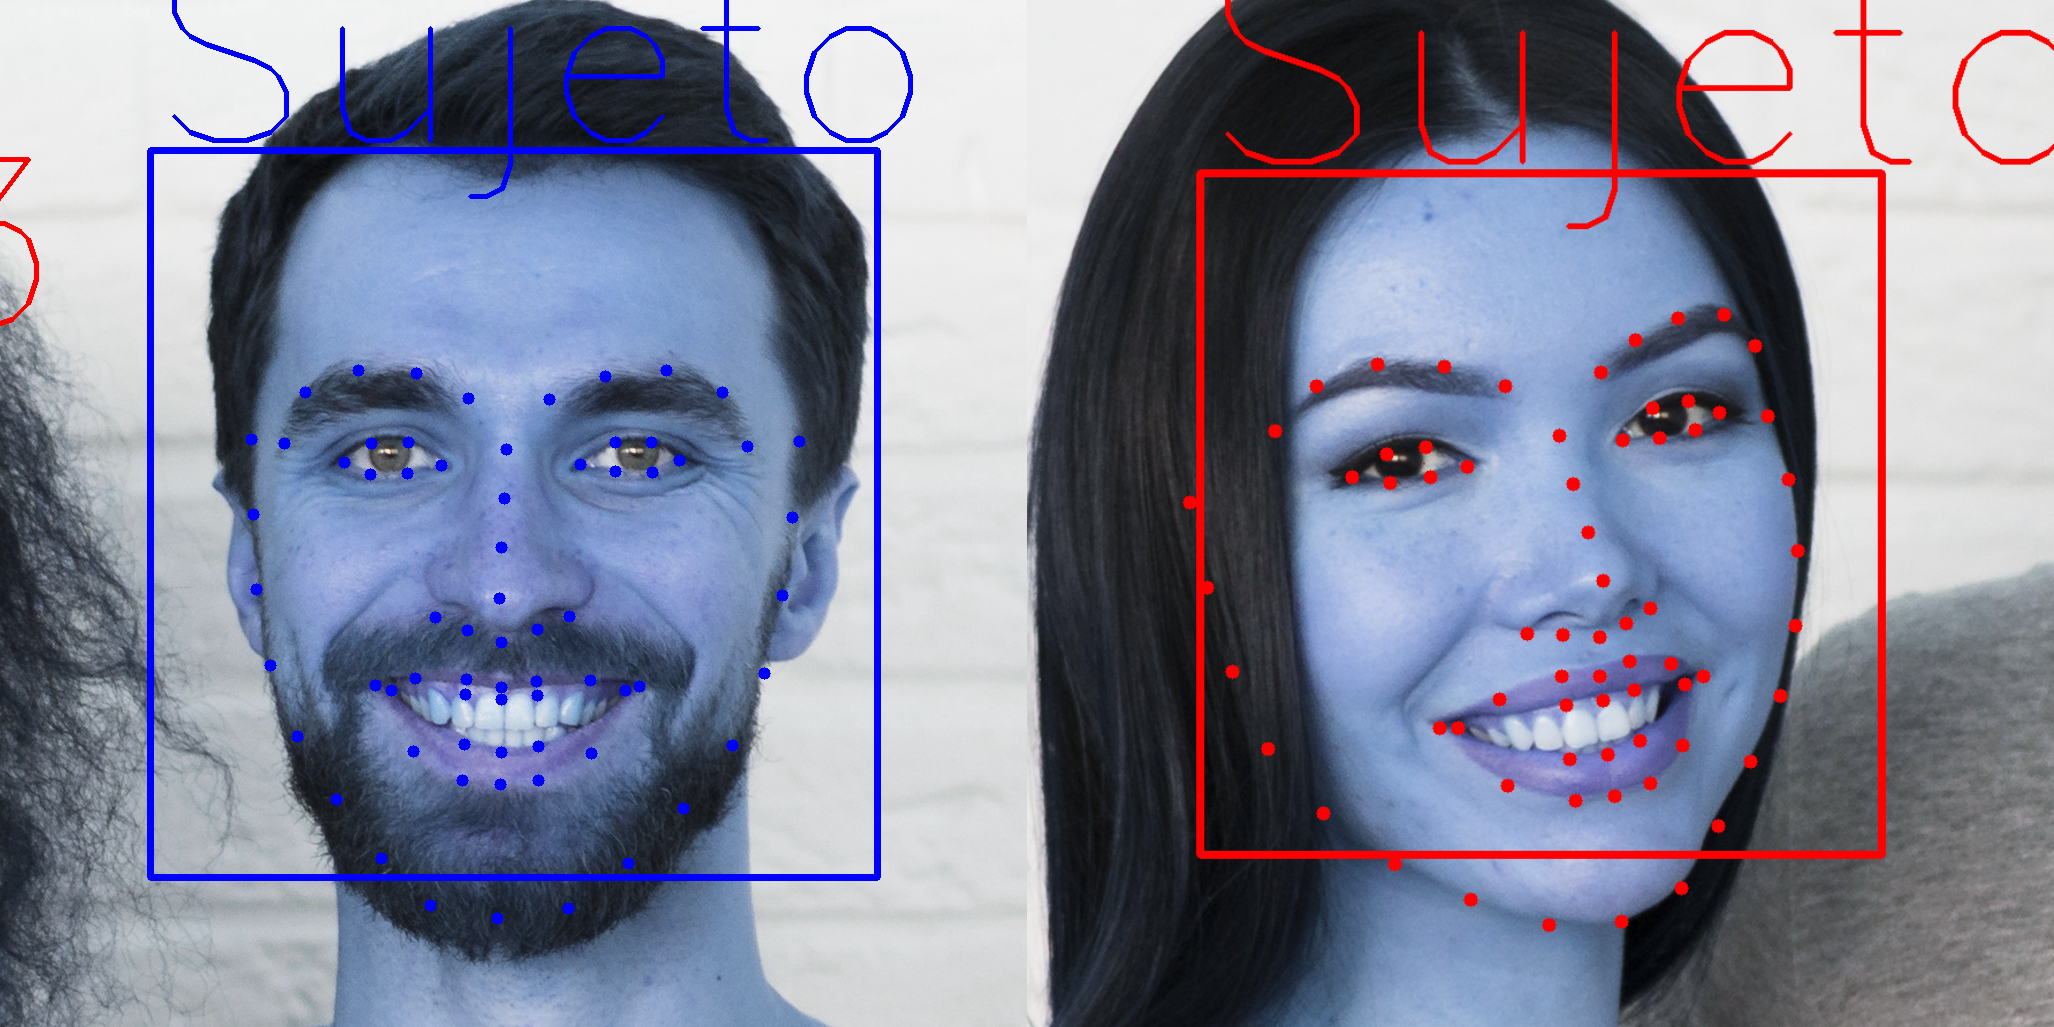

In [104]:
# Procesar y dibujar landmarks de Sujetos 2 [1] y 4 [3]

from google.colab.patches import cv2_imshow

if all_landmarks is not None and len(all_landmarks) >= 1:
  # Landmarks del primer rostro (indice 0)
  landmarks_s2 = all_landmarks[1]
  # Quitar dimensión extra y convertir a enteros
  landmarks_s2 = landmarks_s2[0].astype(int)
  print("Landmarks Sujeto 2 procesados. Forma:", landmarks_s2.shape)

  # Dibujar sobre la imagen 'img_rgb' (que ya tiene boxes/nombres)
  print("\nDibujando landmarks de Sujeto 2:")

if all_landmarks is not None and len(all_landmarks) >= 1:
  # Landmarks del primer rostro (indice 0)
  landmarks_s3 = all_landmarks[3]
  # Quitar dimensión extra y convertir a enteros
  landmarks_s3 = landmarks_s3[0].astype(int)
  print("Landmarks Sujeto 4 procesados. Forma:", landmarks_s3.shape)

  # Dibujar sobre la imagen 'img_with_detections2' (que ya tiene boxes/nombres)
  print("\nDibujando landmarks de Sujeto 4:")

  # Get the bounding box of the first face
  x2, y2, w2, h2 = faces_2[1]

  # Adjust the margin to ensure landmarks are included in the zoomed region
  margin2 = 150

  # Select the region with the face plus a margin
  face_region2 = img_with_detections2[y2 - margin2:y2 + h2 + margin2, x2 - margin2:x2 + w2 + margin2]

  # Iterate through landmarks and draw them on the face_region
  for lx2, ly2 in landmarks_s2:
      # Check if the landmark falls within the zoomed region
      if (x2 - margin2 < lx2 < x2 + w2 + margin2) and (y2 - margin2 < ly2 < y2 + h2 + margin2):
          # Adjust landmark coordinates relative to the zoomed region
          lx2_zoomed = lx2 - (x2 - margin2)
          ly2_zoomed = ly2 - (y2 - margin2)
          cv2.circle(face_region2, (lx2_zoomed, ly2_zoomed), 6, (255, 0, 0), -1)

  # Display the zoomed image with landmarks
  #plt.imshow(face_region2)
  #plt.title("Zoom Landmarks Sujeto2")

  # Get the bounding box of the first face
  x3, y3, w3, h3 = faces_2[3]

  # Select the region with the face plus a margin
  face_region3 = img_with_detections2[y3 - margin2:y3 + h3 + margin2, x3 - margin2:x3 + w3 + margin2]

  # Iterate through landmarks and draw them on the face_region
  for lx3, ly3 in landmarks_s3:
      # Check if the landmark falls within the zoomed region
      if (x3 - margin2 < lx3 < x3 + w3 + margin2) and (y3 - margin2 < ly3 < y3 + h3 + margin2):
          # Adjust landmark coordinates relative to the zoomed region
          lx3_zoomed = lx3 - (x3 - margin2)
          ly3_zoomed = ly3 - (y3 - margin2)
          cv2.circle(face_region3, (lx3_zoomed, ly3_zoomed), 6, (0, 0, 255), -1)

  # Display the zoomed image with landmarks
  #plt.imshow(face_region3)
  #plt.title("Zoom Landmarks Sujeto4")

  # Resize images to the same height before stacking
  max_height = max(face_region2.shape[0], face_region3.shape[0])
  face_region2_resized = cv2.resize(face_region2, (int(face_region2.shape[1] * max_height / face_region2.shape[0]), max_height))
  face_region3_resized = cv2.resize(face_region3, (int(face_region3.shape[1] * max_height / face_region3.shape[0]), max_height))

  # Comparación en una única línea de las imágenes en cada canal.
  print ("Landmarks de los Sujetos 2 y 4")
  comp = np.hstack((face_region2_resized,face_region3_resized))
  cv2_imshow(comp);

else:
  print("No hay landmarks disponibles para procesar.")


### 2.3 **Ejercicio 5:** Procesar y Dibujar Landmarks (Darín)

**Tarea:** Haz lo mismo que en la celda anterior pero para el segundo rostro (Darín, índice 1) y dibuja sus landmarks en rojo sobre la *misma* imagen `img_rgb`.

Hecho en el punto anterior.-
Vamos a hacerlo sin zomm en la imagen original.


Dibujando los landmarks de Sujeto 2 y 4
Landmarks de los Sujetos 2 y 4


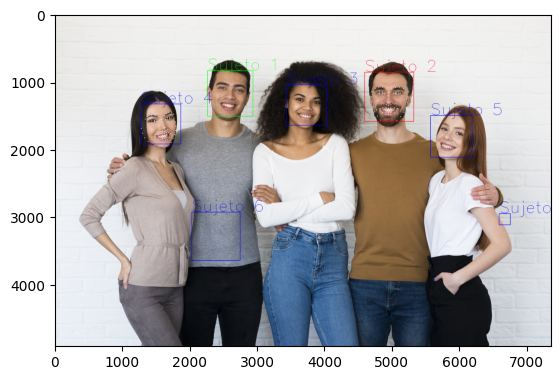

In [105]:
# Procesar y dibujar landmarks de Sujetos 2 [1] y 4 [3]

  # Dibujar sobre la imagen 'img_rgb' (que ya tiene boxes/nombres)
print("\nDibujando los landmarks de Sujeto 2 y 4")

  # Get the bounding box of the first face
x2a, y2a, w2a, h2a = faces_2[1]
  # Get the bounding box of the second face
x3a, y3a, w3a, h3a = faces_2[3]

  # Iterate through landmarks and draw them on the face_region
for lx2a, ly2a in landmarks_s2:
      # Check if the landmark falls within the zoomed region
    if (x2a < lx2a < x2a + w2a) and (y2a < ly2a < y2a + h2a):
        cv2.circle(img_with_detections2, (lx2a, ly2a), 6, (255, 255, 255), -1)

  # Iterate through landmarks and draw them on the face_region
for lx3a, ly3a in landmarks_s3:
      # Check if the landmark falls within the zoomed region
    if (x3a < lx3a < x3a + w3a) and (y3a < ly3a < y3a + h3a):
        cv2.circle(img_with_detections2, (lx3a, ly3a), 6, (255, 255, 255), -1)

  # Comparación en una única línea de las imágenes en cada canal.
print ("Landmarks de los Sujetos 2 y 4")
plt.imshow(img_with_detections2)
plt.show() # Ensure the image is displayed



## Sección 3: Selección y Aplicación de Landmarks

Conociendo el índice de cada landmark (ver imagen de la malla), podemos seleccionar y usar solo los puntos que nos interesan para tareas específicas.

### 3.1 **Ejercicio 6:** Dibujar Ojos y Boca (Pauls)

**Tarea:**
1.  Define listas con los índices correspondientes a los ojos y la boca.
2.  Crea una **copia limpia** de la imagen RGB original (`img_con_partes = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)`).
3.  Itera sobre `landmarks_pauls`.
4.  Dibuja solo los puntos de ojos y boca sobre `img_con_partes` usando colores distintos (Magenta, Azul, Cian).
5.  Muestra un zoom en Pauls de la imagen resultante.

In [ ]:
#Vamos a utilizar una de las imágenes con zoom, para completar la malla con los indices de
#de los landmarkas y así poder seleccionar solo las partes indicadas en la consigna.



In [106]:
# Cargar el detector de landmarks y aplicarlo

if img_gray is not None and len(faces) > 0:
  # Creamos el detector
  landmark_detector = cv2.face.createFacemarkLBF()
  # Cargamos el modelo
  try:
    landmark_detector.loadModel("lbfmodel.yaml")
    print("Modelo LBF cargado.")

    # Aplicamos el detector ('fit')
    # Recibe la imagen GRIS y las bounding boxes 'faces'
    ok, all_landmarks = landmark_detector.fit(img_gray, faces)

    if ok:
      print(f"Se detectaron landmarks para {len(all_landmarks)} rostro(s).")
      # all_landmarks es una lista, cada elemento es un array de landmarks para una cara
    else:
      print("Error durante la detección de landmarks con .fit()")
      all_landmarks = None

  except cv2.error as e:
    print(f"Error cargando o usando el modelo LBF: {e}")
    print("Asegúrate que 'lbfmodel.yaml' se descargó correctamente.")
    all_landmarks = None
else:
  print("Se requiere la imagen gris y las caras detectadas ('faces').")
  all_landmarks = None

Modelo LBF cargado.
Se detectaron landmarks para 1 rostro(s).


Landmarks Sujeto 1 procesados. Forma: (68, 2)

Dibujando landmarks de Sujeto 1:


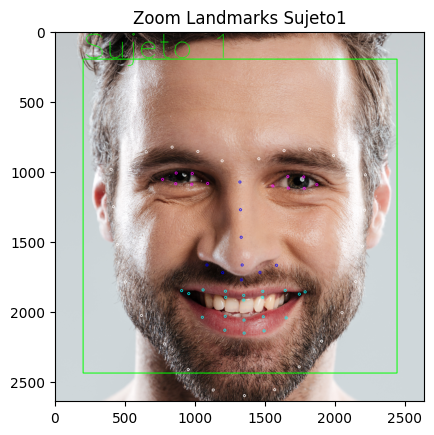

In [107]:
# Procesar y dibujar landmarks de Sujeto1

if all_landmarks is not None and len(all_landmarks) >= 1:
  # Landmarks del primer rostro (indice 0)
  landmarks_s1 = all_landmarks[0]
  # Quitar dimensión extra y convertir a enteros
  landmarks_s1 = landmarks_s1[0].astype(int)
  print("Landmarks Sujeto 1 procesados. Forma:", landmarks_s1.shape)

  # Dibujar sobre la imagen 'img_rgb' (que ya tiene boxes/nombres)
  print("\nDibujando landmarks de Sujeto 1:")

  # Get the bounding box of the first face
  x, y, w, h = faces[0]

  # Adjust the margin to ensure landmarks are included in the zoomed region
  margin = 200

  # Select the region with the face plus a margin
  face_region = img_with_detections[y - margin:y + h + margin, x - margin:x + w + margin]
  face_region_limpia = face_region.copy()

  # Iterate through landmarks and draw them on the face_region
  for i, (lx, ly) in enumerate(landmarks_s1):
      # Check if the landmark falls within the zoomed region
      if (x - margin < lx < x + w + margin) and (y - margin < ly < y + h + margin):
          # Adjust landmark coordinates relative to the zoomed region
          lx_zoomed = lx - (x - margin)
          ly_zoomed = ly - (y - margin)

      if 27 <= i <= 35:
        cv2.circle(face_region_limpia, (lx_zoomed, ly_zoomed), 8, (0, 0, 255), 4) ## Nariz
      if 36 <= i <= 47:
        cv2.circle(face_region_limpia, (lx_zoomed, ly_zoomed), 8, (255, 0, 255), 4) ## Ojos
      if 48 <= i <= 68:
        cv2.circle(face_region_limpia, (lx_zoomed, ly_zoomed), 8, (0, 255, 255), 4)  ## Boca

# Pintaremos de diferentes colores los puntos, según correspondan a los ojos, la nariz o la boca,
# Ojos: Magenta ->  (255, 0, 255)
# Nariz:  Azul -> (0,0,255)
# Boca: Cian -> (0,255,255)

  # Display the zoomed image with landmarks
  plt.imshow(face_region_limpia)
  plt.title("Zoom Landmarks Sujeto1")

else:
  print("No hay landmarks disponibles para procesar.")


## Sección 4: Conclusión y Próximos Pasos

En este laboratorio, hemos integrado la detección de rostros con la localización de landmarks faciales usando OpenCV. Vimos cómo preparar la imagen, aplicar los detectores y visualizar los resultados, incluyendo la selección de puntos específicos.

Estos landmarks son bloques de construcción para aplicaciones más avanzadas como:
*   **Detección de Somnolencia/Bostezos:** Calculando Eye Aspect Ratio (EAR) y Mouth Aspect Ratio (MAR).
*   **Análisis de Expresiones Faciales.**
*   **Realidad Aumentada.**

**Ideas para continuar:**
*   Investiga y calcula EAR y MAR para los rostros detectados.
*   Aplica este flujo de trabajo a otras imágenes o a los fotogramas de un video.